In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint, solve_bvp, solve_ivp, quad
from scipy.optimize import curve_fit

In [128]:
# ---------- Function for parsing infected data ----------  #
def parse_infected_data(file):
    """Parse weekly new case count data.

    All data is in 1-week increments here.
    Testing data starts the week after the training data ends.

    Parameters:
        file (str): The path to "Summary_Case Counts Per Week.csv"

    Returns:
        train (np.ndarray) - An array of weekly new COVID case counts
            for training (the weeks from 3/8/2020 to 12/12/2021).
            Use for your gradient descent algorithm and modeling.
        test (np.ndarray) - An array of weekly new COVID case counts
            for testing (the weeks from 12/19/2021 to 1/19/2022).
            Only use to test the performance of your model on its
            learned parameters after you run your gradient descent
            algorithm.
        t_train (list) - A list of numbered weeks
            corresponding to the training data (starting with 1)
        t_test (list) - A list of numbered weeks
            corresponding to the testing data (starting 1 after
            the training data)
    """
    # Get the case count data from the csv into Python
    data = pd.read_csv(file, index_col=0)
    date_data = data.reset_index()
    dates = date_data.iloc[:, 0].to_numpy()

    # Split the data into a training set(before 12/12/2021)
    # and a testing set (12/19/2021-1/19/2022)
    #train = data[:]['New Cases'].to_numpy()
    train = data[:'2021-12-12']['New Cases'].to_numpy()
    test = data['2021-12-19':'2022-01-19']['New Cases'].to_numpy()

    # Get week enumerations for this data (for ease of use)
    t_train = [i for i in range(1, len(train) + 1)]
    t_test = [i for i in range(len(train)+1, len(test)+len(train)+1)]
    return train, test, t_train, t_test, dates



# ---------- Example for how to use the above function ----------  #
csv_file = 'COVID_Data_SLC/Summary_Case Counts per Week.csv'
case_count_data, case_count_pred, t_cc_data, t_cc_pred, dates = parse_infected_data(csv_file)


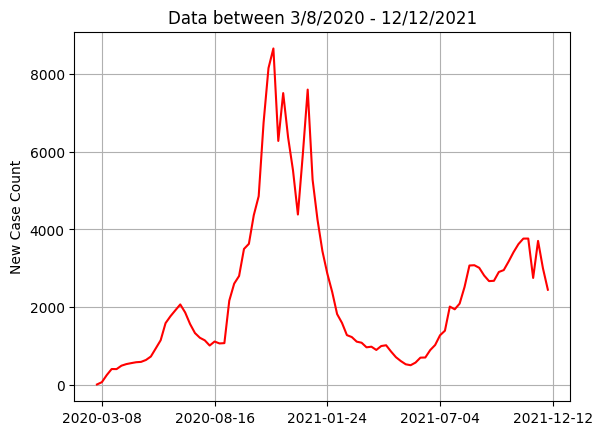

In [229]:
plt.plot(case_count_data, c='r')
plt.ylabel("New Case Count")
plt.xticks(t_cc_data[::23], dates[:len(case_count_data):23])
plt.title("Data between 3/8/2020 - 12/12/2021")
plt.grid()
plt.savefig("graphics/new_case.png")

In [130]:
len(case_count_data)

93

In [183]:
# Estimate of the total Salt Lake County population in 2020 (https://www.census.gov/quickfacts/fact/table/saltlakecountyutah/PST045224)
P_total = 1e6

In [186]:
# I_data and R_data is generated with the assumption that COVID lasts for 4 weeks total. 
# Therefore, I_data is the sum of the new cases from the past 4 weeks and R_data is the sum of every new case up til the past 4 weeks.

I_data = np.array([sum(case_count_data[:k]) for k in range(1, 4)] + \
                  [sum(case_count_data[k:k+4]) for k in range(len(case_count_data) - 3)])
R_data = np.array([0, 0, 0] + [sum(case_count_data[:k]) for k in range(len(case_count_data) - 3)])

I_data = I_data / P_total
R_data = R_data / P_total
S_data = 1 - I_data - R_data

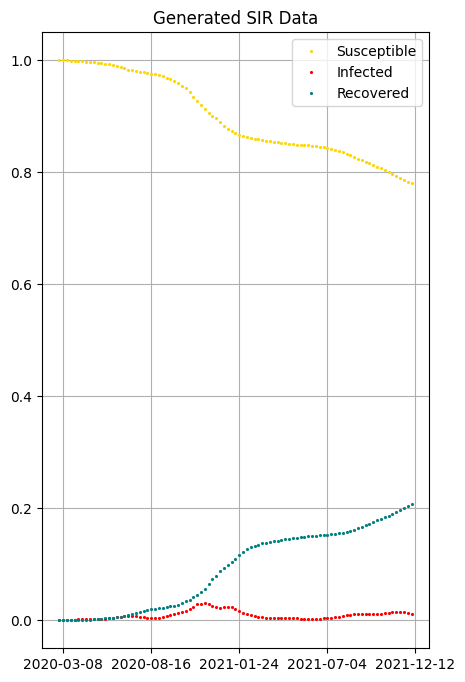

In [228]:
fig = plt.figure(figsize=(5, 8))

plt.plot(S_data, c='gold', linestyle="none", marker='.', markersize=2.5, label="Susceptible")
plt.plot(I_data, c='red', linestyle="none", marker='.', markersize=2.5, label="Infected")
plt.plot(R_data, c='teal', linestyle="none", marker='.', markersize=2.5, label="Recovered")

plt.xticks(t_cc_data[::23], dates[:len(case_count_data):23])
plt.legend()
plt.grid()
plt.title("Generated SIR Data")
plt.savefig("graphics/gen_SIR_data.png")

In [134]:
N = len(t_cc_data)
c = 1
a = np.zeros(5)
b = np.zeros(5)
k = lambda x: c + sum(a[i]*np.cos(2*np.pi*x*i / 52) + b[i]*np.sin(2*np.pi*x*i / 52) for i in range(len(a)))
#time_steps = np.linspace(0, N / 52, N, endpoint=False)
time_steps = np.array(t_cc_data)

In [232]:
# Create a callable observation function in the time domain for I and R

I_obs = np.poly1d(np.polyfit(time_steps, I_data, 20))
R_obs = np.poly1d(np.polyfit(time_steps, R_data, 20))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


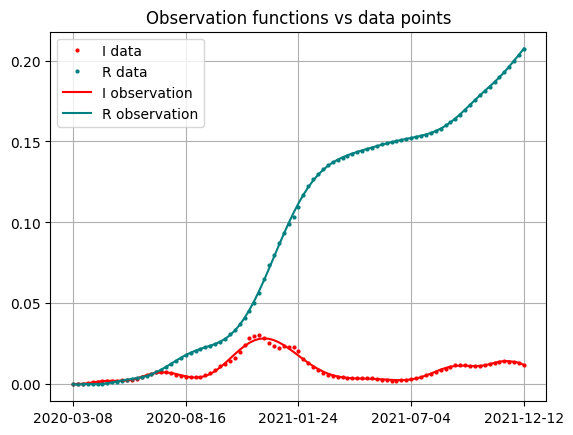

In [251]:
plt.plot(time_steps, I_data, color='red', linestyle='none', marker='o', label='I data', ms = 2)
plt.plot(time_steps, R_data, color='teal', linestyle='none', marker='o', label='R data', ms = 2)

plt.plot(time_steps, I_obs(time_steps), 'red', label="I observation")
plt.plot(time_steps, R_obs(time_steps), 'teal', label="R observation")

plt.legend(loc='upper left')
plt.xticks(t_cc_data[::23], dates[:len(case_count_data):23])
plt.title("Observation functions vs data points")
plt.grid()
plt.savefig("graphics/obs_vs_data.png")


In [252]:
def fourier_series(t, *args):
    t = np.array(t)
    N = (len(args) - 1) // 2
    c = args[0]
    a = args[1:N+1]
    b = args[N+1:]
    return c + sum(a[i]*np.cos(2*np.pi*t*i/52) + b[i]*np.sin(2*np.pi*t*i/52) for i in range(N))


In [253]:
k = lambda c, a, b, x: c + sum(a[i]*np.cos(2*np.pi*x*i/52) + b[i]*np.sin(2*np.pi*x*i/52) for i in range(len(a)))
q = lambda c, a, b, x: c + sum(a[i]*np.cos(2*np.pi*x*i/52) + b[i]*np.sin(2*np.pi*x*i/52) for i in range(len(a)))

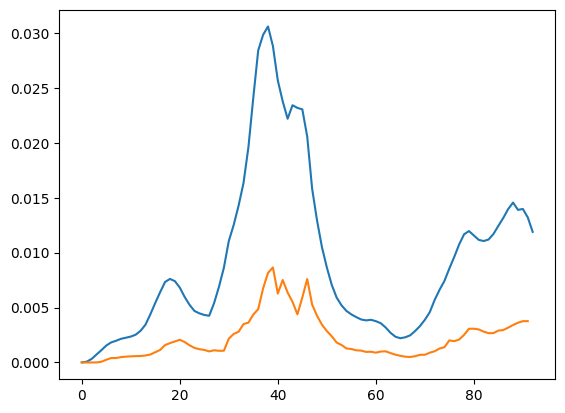

In [257]:
R_t = R_data[1:] - R_data[:-1]
plt.plot(I_data)
plt.plot(R_t)

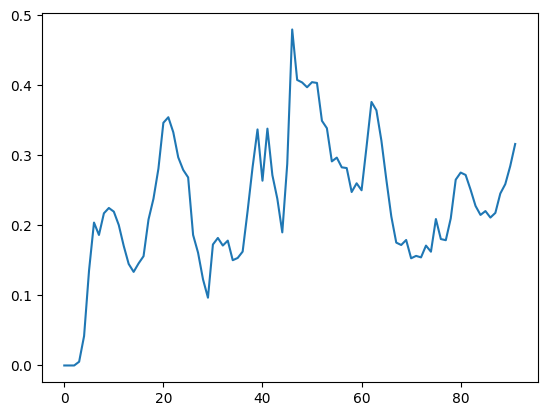

In [263]:
q_data = R_t / I_data[1:]
plt.plot(q_data)

In [259]:
q_guess, _ = curve_fit(fourier_series, t_cc_data[:-1], q_data, p0=(0.2, *np.zeros(10), *np.zeros(10)))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


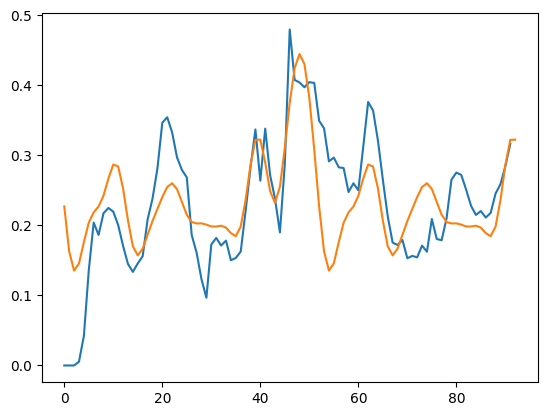

In [260]:
plt.plot(q_data)
plt.plot(fourier_series(t_cc_data, *q_guess))

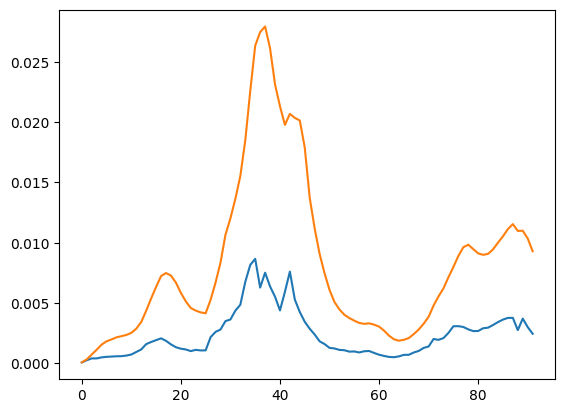

In [271]:
S_t = S_data[1:] - S_data[:-1]
plt.plot(-S_t)
plt.plot(S_data[1:]*I_data[1:])

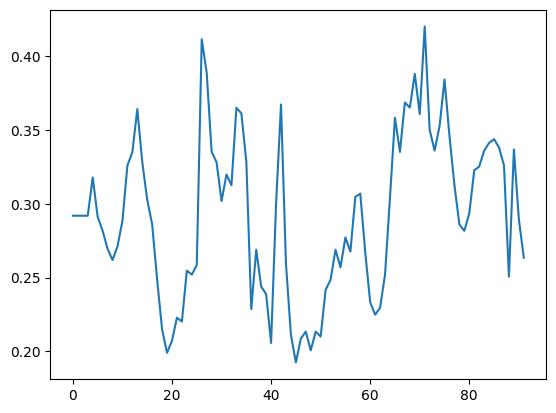

In [289]:
k_data = -S_t / (S_data[1:]*I_data[1:])
k_data[:4] = np.mean(k_data[5:])
plt.plot(k_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


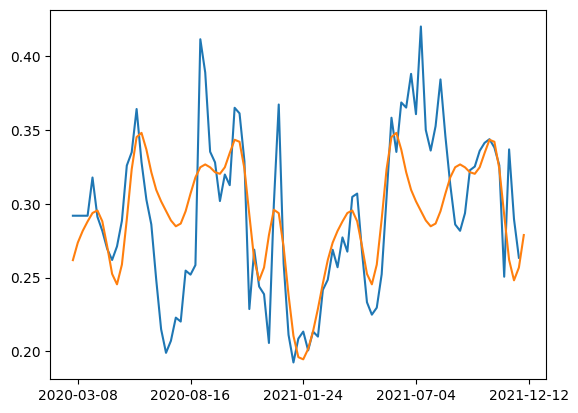

In [292]:
k_guess, _ = curve_fit(fourier_series, t_cc_data[:-1], k_data, p0=(0.3, *np.zeros(10), *np.zeros(10)))
plt.plot(k_data)
plt.plot(fourier_series(t_cc_data, *k_guess))
plt.xticks(t_cc_data[::23], dates[:len(case_count_data):23])
plt.show()

In [152]:
def ode_fun(t, u, *args):
    N = len(args) // 2

    out = np.zeros(3)

    S = u[0]
    I = u[1]
    R = u[2]

    out[0] = -fourier_series(t, *args[:N])*S*I
    out[1] = fourier_series(t, *args[:N])*S*I-fourier_series(t, *args[N:])*I
    out[2] = fourier_series(t, *args[N:])*I

    return out

# Initial guess
I0 = 0.0006
R0 = R_data[0]
S0 = 1 - I0 - R0

u0 = [S0, I0, R0]
SIR_sol = solve_ivp(ode_fun, [0, 93], u0, args=(*k_guess, *q_guess), dense_output=True)

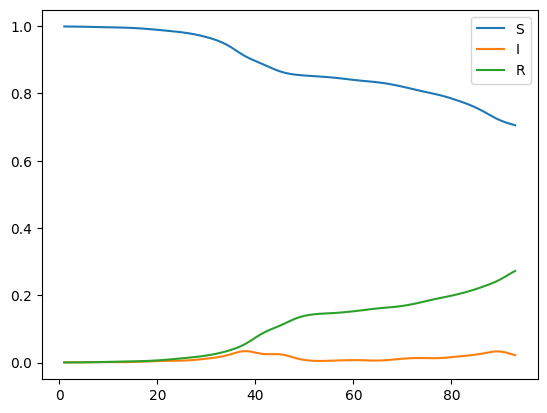

In [153]:
plt.plot(time_steps, SIR_sol.sol(time_steps)[0], label="S")
plt.plot(time_steps, SIR_sol.sol(time_steps)[1], label="I")
plt.plot(time_steps, SIR_sol.sol(time_steps)[2], label="R")
plt.legend()
plt.show()

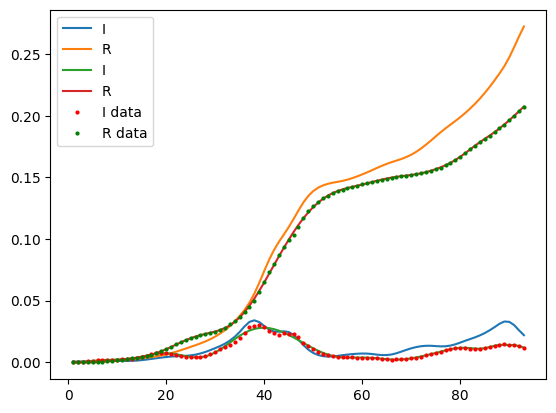

In [154]:
plt.plot(time_steps, SIR_sol.sol(time_steps)[1], label="I")
plt.plot(time_steps, SIR_sol.sol(time_steps)[2], label="R")
plt.plot(time_steps, I_poly(time_steps), label="I")
plt.plot(time_steps, R_poly(time_steps), label="R")
plt.plot(time_steps, I_data,'ro', label='I data', ms = 2)
plt.plot(time_steps, R_data,'go', label='R data', ms = 2)
plt.legend()
plt.show()

In [183]:
def ode_adjoint(t, P):
    S = SIR_sol.sol(t)[0]
    I = SIR_sol.sol(t)[1]
    R = SIR_sol.sol(t)[2]
    
    P_S = fourier_series(t, *k_guess)*I*(P[0] - P[1])
    P_I = I - I_poly(t) + fourier_series(t, *k_guess)*S*(P[0] - P[1]) + fourier_series(t, *q_guess)*(P[1] - P[2])
    P_R = R - R_poly(t)

    return np.vstack([P_S, P_I, P_R])

def adjoint_bc(Pa, Pb):
    return np.array([Pb[0], Pb[1], Pb[2]])

t_mesh = np.linspace(0, 93, 10)
P0 = np.ones((3, t_mesh.size))
p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0)

In [184]:
J_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
J_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])

J_k = sum(J_k_func(t) for t in time_steps)
J_q = sum(J_q_func(t) for t in time_steps)
J_S0 = -p.sol(0)[0]
J_I0 = -p.sol(0)[1]
J_R0 = -p.sol(0)[2]

J_k, J_q, J_S0, J_I0, J_R0

(5.877246869273374,
 -5.850595936316135,
 1.9515100602702726,
 172.52548515763993,
 1.081922957761723)

In [185]:
np.set_printoptions(suppress=True, precision=8)

In [186]:
N = len(t_cc_data)
num_coefs = 10
k = np.copy(k_guess)
q = np.copy(q_guess)
I0 = 0.0006
R0 = 0
S0 = 1 - I0 - R0
u0 = np.array([S0, I0, R0])

n_iter = 100
lr = 0.01

cost_hist = []
param_hist = []

In [240]:
n_iter = 100
lr = 0.0001
for i in range(n_iter):
    print("Step {}".format(i))

    SIR_sol = solve_ivp(ode_fun, [0, 100], u0, args=(*k, *q), dense_output=True)

    cost_func = lambda t: (SIR_sol.sol(t)[1] - I_poly(t))**2 + (SIR_sol.sol(t)[2] - R_poly(t))**2 
    J = 0.5 * sum(cost_func(t) for t in range(N+1))
    print("Cost: {:.6}".format(J))
    cost_hist.append(J)

    def ode_adjoint(t, P):
        S = SIR_sol.sol(t)[0]
        I = SIR_sol.sol(t)[1]
        R = SIR_sol.sol(t)[2]
        
        P_S = fourier_series(t, *k)*I*(P[0] - P[1])
        P_I = I - I_poly(t) + fourier_series(t, *k)*S*(P[0] - P[1]) + fourier_series(t, *q)*(P[1] - P[2])
        P_R = R - R_poly(t)

        return np.vstack([P_S, P_I, P_R])

    def adjoint_bc(Pa, Pb):
        return np.array([Pb[0], Pb[1], Pb[2]])

    t_mesh = np.linspace(0, 93, 10)
    P0 = np.ones((3, t_mesh.size))
    p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0)

    J_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
    J_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])

    J_c_k = sum(J_k_func(t) for t in range(N+1))
    J_a_k = []
    J_b_k = []

    J_c_q = sum(J_q_func(t) for t in range(N+1))
    J_a_q = []
    J_b_q = []
    
    for i in range(1, num_coefs+1):
        J_a_k.append(sum(J_k_func(t)*np.cos(2*np.pi*t*i/52) for t in time_steps))
        J_b_k.append(sum(J_k_func(t)*np.sin(2*np.pi*t*i/52) for t in time_steps))
        J_a_q.append(sum(J_q_func(t)*np.cos(2*np.pi*t*i/52) for t in time_steps))
        J_b_q.append(sum(J_q_func(t)*np.sin(2*np.pi*t*i/52) for t in time_steps))

    J_S0 = -p.sol(0)[0]
    J_I0 = -p.sol(0)[1]
    J_R0 = -p.sol(0)[2]

    u_grad = np.array([J_I0 - J_S0, J_R0 - J_S0])
    k_grad = np.array([J_c_k] + J_a_k + J_b_k)
    q_grad = np.array([J_c_q] + J_a_q + J_b_q)

    # print(u0)
    # print(k)
    # print(q)
    # print()

    # print(u_grad)
    # print(k_grad)
    # print(q_grad)
    # print()
    k -= lr*k_grad / np.linalg.norm(k_grad)
    q -= lr*q_grad / np.linalg.norm(q_grad)
    u0[1:] -= 0.001*lr*u_grad / np.linalg.norm(u_grad)
    u0[0] = 1 - u0[1] - u0[2]

    # print(u0)
    # print(k)
    # print(q)

    
    print()



    

Step 0
Cost: 0.00188883

Step 1
Cost: 0.0019153

Step 2
Cost: 0.00189405

Step 3
Cost: 0.00189339

Step 4
Cost: 0.001901

Step 5
Cost: 0.00189415

Step 6
Cost: 0.00191806

Step 7
Cost: 0.00189841

Step 8
Cost: 0.00189957

Step 9
Cost: 0.00190019

Step 10
Cost: 0.00190248

Step 11
Cost: 0.00190106

Step 12
Cost: 0.00191124

Step 13
Cost: 0.00190204

Step 14
Cost: 0.00192359

Step 15
Cost: 0.00190548

Step 16
Cost: 0.00190878

Step 17
Cost: 0.00192149

Step 18
Cost: 0.00191343

Step 19
Cost: 0.00191716

Step 20
Cost: 0.00193583

Step 21
Cost: 0.00191901

Step 22
Cost: 0.00194286

Step 23
Cost: 0.00192098

Step 24
Cost: 0.00193268

Step 25
Cost: 0.00192927

Step 26
Cost: 0.00194439

Step 27
Cost: 0.00192891

Step 28
Cost: 0.00193097

Step 29
Cost: 0.00192943

Step 30
Cost: 0.00194135

Step 31
Cost: 0.00193407

Step 32
Cost: 0.00194725

Step 33
Cost: 0.00194305

Step 34
Cost: 0.00194994

Step 35
Cost: 0.0019603

Step 36
Cost: 0.00193247

Step 37
Cost: 0.00196818

Step 38
Cost: 0.00196317



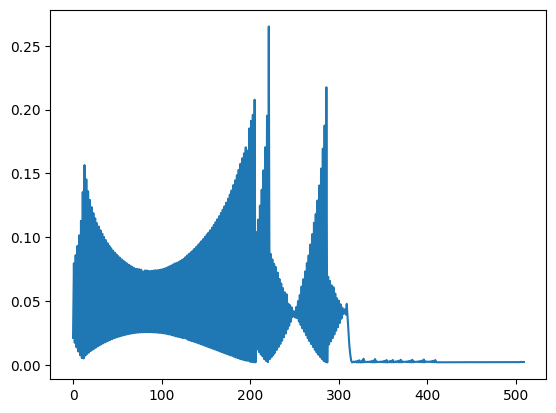

In [241]:
plt.plot(cost_hist)

In [242]:
k

array([ 21.48012397, -21.1845004 ,  -0.0807948 ,  -0.02764075,
         0.01421414,  -0.00604002,  -0.01636912,   0.01454157,
         0.00817443,  -0.0026999 ,  -0.00360821,   0.00830621,
         0.0118296 ,   0.03795195,   0.00756799,   0.03519522,
         0.01969271,  -0.0021356 ,  -0.0159613 ,   0.00896079,
         0.00591059])

In [243]:
q

array([-13.88231604,  14.13734037,   0.06288927,   0.01854841,
        -0.01756716,   0.01970772,   0.02522764,  -0.01396356,
        -0.01372108,   0.00469417,   0.01161835,  -0.00836024,
        -0.02679175,  -0.06193763,  -0.03677598,  -0.04801792,
        -0.02988494,  -0.02590475,  -0.0096641 ,  -0.00235024,
        -0.00059197])

In [244]:
u0

array([0.99941608, 0.00057641, 0.00000751])

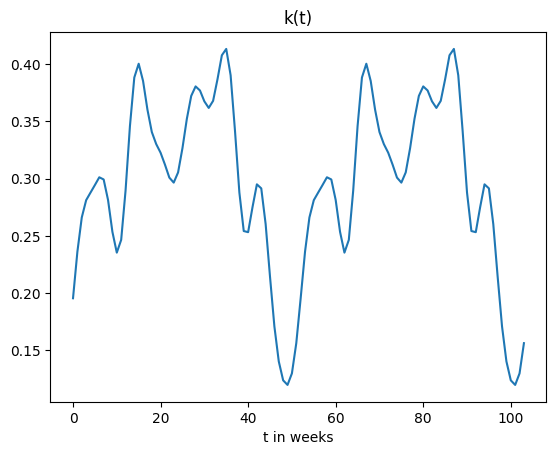

In [250]:
t = np.arange(104)
fig = plt.figure()
plt.plot(fourier_series(t, *k))
plt.title("k(t)")
plt.xlabel("t in weeks")
plt.show()
fig.savefig("SIR1_k.png")

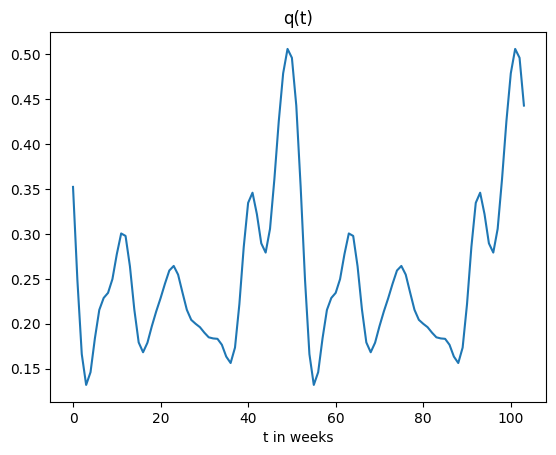

In [251]:
fig = plt.figure()
plt.plot(fourier_series(t, *q))
plt.title("q(t)")
plt.xlabel("t in weeks")
plt.show()
fig.savefig("SIR1_q.png")

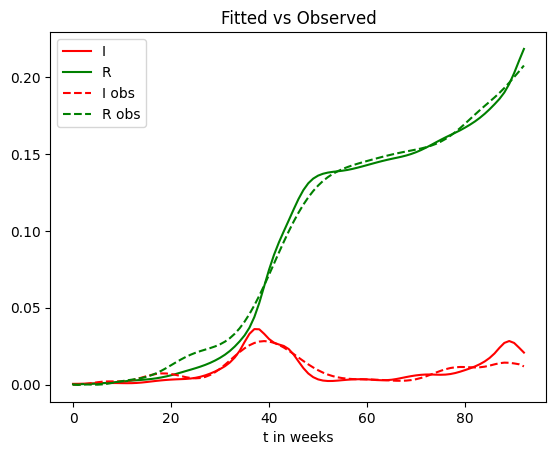

In [255]:
fig = plt.figure()
plt.plot(SIR_sol.sol(t_cc_data)[1], "r", label="I")
plt.plot(SIR_sol.sol(t_cc_data)[2], "g", label="R")
plt.plot(I_poly(t_cc_data), "r--", label="I obs")
plt.plot(R_poly(t_cc_data), "g--", label="R obs")
plt.legend()
plt.xlabel("t in weeks")
plt.title("Fitted vs Observed")
plt.show()
fig.savefig("SIR1_FvO.png")

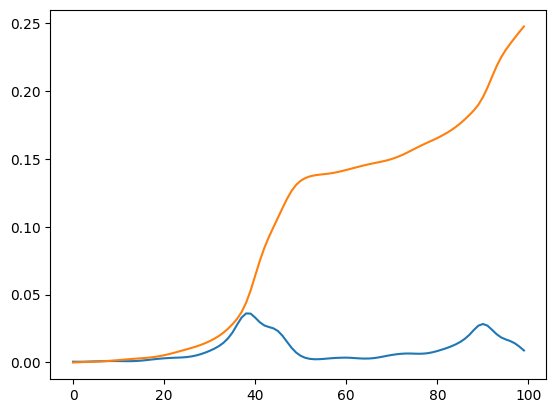

In [248]:
t = np.arange(100)
plt.plot(SIR_sol.sol(t)[1])
plt.plot(SIR_sol.sol(t)[2])

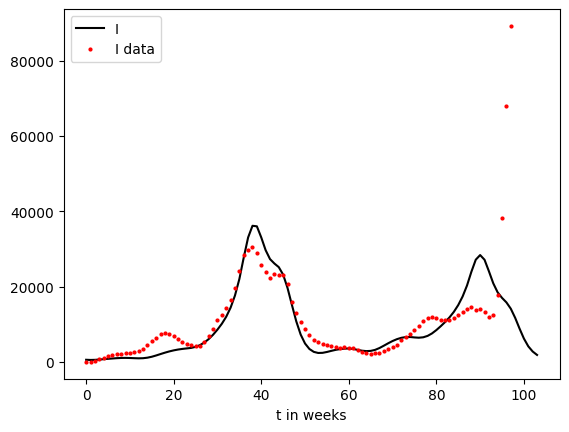

In [294]:
all_case_data = np.concatenate((case_count_data, case_count_pred))
I_full_data = np.array([sum(all_case_data[:k]) for k in range(1, 4)] + [sum(all_case_data[k:k+4]) for k in range(len(all_case_data) - 3)])
fig = plt.figure()
plt.plot(SIR_sol.sol(t)[1]*P_total, 'k', label="I")
plt.plot(I_full_data,'ro', label='I data', ms = 2)
plt.legend()
plt.xlabel("t in weeks")
plt.plot()
fig.savefig("SIR1_pred1.png")

In [277]:
week1_pred = I_data[-1] * S[-1] * fourier_series(94, *k)
I_new1 = week1_pred + I_data[-1] - case_count_data[-4] / P_total
S_new1 = S[-1] - week1_pred

week2_pred = I_new1 * S_new1 * fourier_series(95, *k)
I_new2 = week2_pred + I_new1 - case_count_data[-3] / P_total
S_new2 = S_new1 - week2_pred

week3_pred = I_new2 * S_new2 * fourier_series(96, *k)
I_new3 = week3_pred + I_new2 - case_count_data[-2] / P_total
S_new3 = S_new2 - week3_pred

week4_pred = I_new3 * S_new3 * fourier_series(97, *k)
I_new4 = week4_pred + I_new3 - case_count_data[-1] / P_total
S_new4 = S_new3 - week4_pred

week5_pred = I_new4 * S_new4 * fourier_series(98, *k)

In [280]:
predictions = np.array([week1_pred, week2_pred, week3_pred, week4_pred, week5_pred]) * P_total

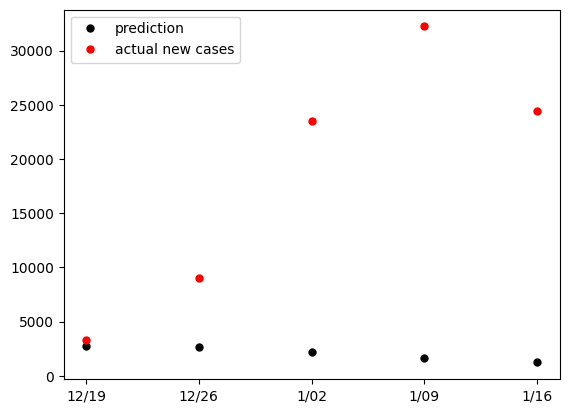

In [293]:
fig = plt.figure()
plt.plot(["12/19","12/26","1/02","1/09","1/16"], predictions, 'ko', ms=5, label="prediction")
plt.plot(["12/19","12/26","1/02","1/09","1/16"], case_count_pred, 'ro', ms=5, label="actual new cases")
plt.legend()
plt.show()
fig.savefig("SIR1_pred2.png")

In [261]:
case_count_pred

array([ 3261,  9057, 23472, 32227, 24435])